<a href="https://colab.research.google.com/github/andreac941/ComputerVision-Eq3/blob/main/10_3_GPT_Web_scrapping_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**10.3 Actividad: GPT y Web-Scraping**

Equipo 20:
* Andrea Carolina Treviño Garza A01034993

##**Instrucciones:**

En la actividad de esta semana trabajarás en equipos mediante el uso del Transformer GPT y comentarios de usuarios obtenidos mediante WebScraping en Tripadvisor.

A través de Tripadvisor ( https://www.tripadvisor.es/ ) en español obtendremos los comentarios de
usuarios sobre su experiencia en un hotel en particular. En esta plataforma se evalúa la experiencia
mediante puntos de 1 a 5, que corresponden de manera ascendente a “Pésimo”, “Malo”, “Normal”,
“Muy bueno” y “Excelente”.

Una de las formas en que se han venido utilizando los generadores de texto como el GPT, es para
generar datos sintéticos de texto que no tengan problemas de privacidad. En particular en esta actividad
los usaremos para generar datos sintéticos sobre comentarios positivos y negativos de usuarios y
posteriormente los usaremos para ver si ayudan a mejor el desempeño de un modelo de clasificación.

De la siguiente liga de Tripadvisor selecciona un hotel en la zona de la ciudad de Monterrey, México, que
consideres adecuado para extraer los comentarios de español y evaluaciones de usuarios:
* https://www.tripadvisor.es/Hotels-g150782-Monterrey_Northern_Mexico-Hotels.html

En particular trata de seleccionar algún hotel cuyas calificaciones consideres desbalanceadas, al verlo
como un problema binario: Positivo (4, 5) y Negativo (1, 2 3).

In [ ]:
#Se instalan los requerimientos para actividad:
!pip install -U transformers
!pip install -U accelerate
!pip install xformers
!pip install evaluate
!apt-get install git-lfs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 53.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 90.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 58.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 6.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.1/109.1 MB 8.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
#Se importan liberías requeridas para la actividad:
import pandas as pd
import numpy as np

import requests
import re
import evaluate

from bs4 import BeautifulSoup as soup
from random import randint
from time import sleep

from transformers import AutoModelForCausalLM, AutoModelForSequenceClassification, AutoTokenizer
from transformers import pipeline, set_seed, TrainingArguments, Trainer
from transformers import DataCollatorWithPadding
import torch
from sklearn.model_selection import train_test_split
from datasets import Dataset, load_metric

##**Ejercicios:**

1. **Mediante web scraping realiza una extracción de los comentarios y calificaciones a dicho hotel. Recuerda que Tripadvisor representa las calificaciones mediante círculos verdes. Los comentarios deben ser de usuarios que los redactaron en idioma en español. Indica la cantidad de comentarios y sus calificaciones que extrajiste.**

In [ ]:
#El hotel que seleccionamos fue "Fiesta Americana Monterrey Pabellón M":

url = "https://www.tripadvisor.es/Hotel_Review-g150782-d9137890-Reviews-Fiesta_Americana_Monterrey_Pabellon_M-Monterrey_Northern_Mexico.html"

html = requests.get(url,
                    headers={"User-Agent": "Mozilla/5.0 (X11; CrOS x86_64 12871.102.0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/81.0.4044.141 Safari/537.36"}
                    )

print(html.status_code)

200


In [ ]:
#Se crea lista para guardar todos los links con los comentarios en español del hotel:
links = []
max_or_num = 645
reviews_x_pages = 5

for k in range(0, max_or_num, reviews_x_pages):
  a = url
  if k == 0:
    ss = '{}'     # Para la primera página es el -or con valor vacío.
  else:
    ss = str(k)  # convertimos a string el valor numérico.
  a = a[:(a.find('Reviews')+7)] + '-or' + ss + a[(a.find('Reviews')+7):]  # Los índices de "Reviews" van de 0 a 6, ya que tiene 7 letras.
  links.append(a)

links

['https://www.tripadvisor.es/Hotel_Review-g150782-d9137890-Reviews-or{}-Fiesta_Americana_Monterrey_Pabellon_M-Monterrey_Northern_Mexico.html',
 'https://www.tripadvisor.es/Hotel_Review-g150782-d9137890-Reviews-or5-Fiesta_Americana_Monterrey_Pabellon_M-Monterrey_Northern_Mexico.html',
 'https://www.tripadvisor.es/Hotel_Review-g150782-d9137890-Reviews-or10-Fiesta_Americana_Monterrey_Pabellon_M-Monterrey_Northern_Mexico.html',
 'https://www.tripadvisor.es/Hotel_Review-g150782-d9137890-Reviews-or15-Fiesta_Americana_Monterrey_Pabellon_M-Monterrey_Northern_Mexico.html',
 'https://www.tripadvisor.es/Hotel_Review-g150782-d9137890-Reviews-or20-Fiesta_Americana_Monterrey_Pabellon_M-Monterrey_Northern_Mexico.html',
 'https://www.tripadvisor.es/Hotel_Review-g150782-d9137890-Reviews-or25-Fiesta_Americana_Monterrey_Pabellon_M-Monterrey_Northern_Mexico.html',
 'https://www.tripadvisor.es/Hotel_Review-g150782-d9137890-Reviews-or30-Fiesta_Americana_Monterrey_Pabellon_M-Monterrey_Northern_Mexico.html',


In [ ]:
#Se generan listas para almacenar todos los comentarios (reviews) y sus calificaciones (de 1 a 5 estrellas en lista stars):
reviews = []   # tarda como 15 min.
stars =[]

numpages = int( max_or_num / reviews_x_pages )

for link in links[0:numpages]:
  print(link)

  headers = {'User-Agent':'Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.97 Safari/537.36' }
  html2 = requests.get(link, headers=headers)

  sleep(randint(1,5))   # se incluyen intervalos de sleep para que no se estén haciendo llamadas de manera continua a la página
                        # y que al detectar esta actividad continua, se pueda detectar como una actividad sospechosa por el servidor
                        # y nos pueda bloquear de manera automática por ello.
  bsobj2 = soup(html2.content,'lxml')   # objeto de la librería BeautifulSoup para llevar a cabo nuestra tarea.

  # Extraemos los comentarios de cualquiera de las siguientes dos formas:
  # Incluimos algunos Print solo para visualizar la manera en que se lleva a cabo el proceso:

  #for review in bsobj2.findAll('span', class_='QewHA'):       # Forma 1:  Estamos en "span", Observa el guión-bajo al final de "class_"
  for review in bsobj2.findAll('span', {'class' : 'QewHA'}):   # Forma 2
      print(review.text)
      reviews.append(review.text.strip())

  sleep(randint(1,5))
  bsobj3 = soup(html2.content,'lxml')

  # Extraigamos también las calificaciones (estrellas):
  # Observa que las calificaciones están en unidades de 10, 20, 30, 40, 50.
  # En particular en este caso haremos la extracción de todo el string donde se encuentra la
  # calificación al hotel por parte del usuario y a partir de ahí mediante regex puedes
  # fácilmente realizar la extracción de la calificación:
  for cal in bsobj3.findAll('div', {'class' : 'Hlmiy'}):
    print(cal)
    #  Aquí puedes incluir tu regex para extraer solo la calificación numérica.
    stars.append(cal)

https://www.tripadvisor.es/Hotel_Review-g150782-d9137890-Reviews-or{}-Fiesta_Americana_Monterrey_Pabellon_M-Monterrey_Northern_Mexico.html
Hotel con muy buena vista a la CD, es muy silencioso y cómodo, es sencillo llegar a la habitación, es muy cómoda. Tiene lo necesario para hospedarse de primera, el aire acondicionado funciono a la perfección, el baño es adecuado y espacioso, la reseña me pidió evaluar la alberca, pero no me informaron de que contenía alberca y la descripción del hotel tampoco se mencionó que tenía, por lo demás excelente 
Desde que llegamos la atención fue excelente por parte del personal, lo que extraño es el servicio de valet parking, ya que aunque tienen un área reservado para el hotel, es un poco complicado llegar.
Las instalaciones del hotel están muy bien cuidadas, pasillos, habitaciones y en general todo el hotel tiene un olor espectacular, cuidan detalles que otros no lo harían. El servicio de room service bueno aunque un poco limitado en las opciones del me

In [ ]:
#Se imprimen la cantidad de comentarios y sus calificaciones extraídos:
print('Cantidad de comentarios extraídos:', len(reviews))
print('Cantidad de clasificaciones:', len(stars))

Cantidad de comentarios extraídos: 645
Cantidad de clasificaciones: 645


In [ ]:
#Se observa formato de lista stars:
stars[0:5]

[<div class="Hlmiy F1" data-test-target="review-rating"><span class="ui_bubble_rating bubble_50"></span></div>,
 <div class="Hlmiy F1" data-test-target="review-rating"><span class="ui_bubble_rating bubble_50"></span></div>,
 <div class="Hlmiy F1" data-test-target="review-rating"><span class="ui_bubble_rating bubble_40"></span></div>,
 <div class="Hlmiy F1" data-test-target="review-rating"><span class="ui_bubble_rating bubble_50"></span></div>,
 <div class="Hlmiy F1" data-test-target="review-rating"><span class="ui_bubble_rating bubble_50"></span></div>]

In [ ]:
#Se "limpia" lista stars, para obtener el dato correspondiente únicamenete a la cantidad de estrellas:
#Primero se convierte a string cada calificación:
clean_stars = []
for x in stars:
  clean_stars.append(str(x))

#Se extrae el dato con slice, escribiendo la posición/index correspondiente a la cantidad de estrellas (10 - 1 estrella, 20 - 2 estrellas, 30 - 3 estrellas, 40 - 4 estrellas y 50 - 5 estrellas)
clean_stars1 = []
for x1 in clean_stars:
  clean_stars1.append(x1[92:94])

print(clean_stars[0:5])
print(clean_stars1[0:5])

['<div class="Hlmiy F1" data-test-target="review-rating"><span class="ui_bubble_rating bubble_50"></span></div>', '<div class="Hlmiy F1" data-test-target="review-rating"><span class="ui_bubble_rating bubble_50"></span></div>', '<div class="Hlmiy F1" data-test-target="review-rating"><span class="ui_bubble_rating bubble_40"></span></div>', '<div class="Hlmiy F1" data-test-target="review-rating"><span class="ui_bubble_rating bubble_50"></span></div>', '<div class="Hlmiy F1" data-test-target="review-rating"><span class="ui_bubble_rating bubble_50"></span></div>']
['50', '50', '40', '50', '50']


In [ ]:
#Se crea dataFrame de comentarios (review) y estrellas (stars) para posteriormente poderlo expertar a .cvs:
df = pd.DataFrame(reviews, columns=['review'])
df['stars'] = clean_stars1
df.head()

,review,stars
0,"Hotel con muy buena vista a la CD, es muy sile...",50
1,Desde que llegamos la atención fue excelente p...,50
2,Las instalaciones del hotel están muy bien cui...,40
3,"Una experiencia muy placentera, excelente serv...",50
4,"Pabellón M es increíble, tener la posibilidad ...",50


In [ ]:
#Se guarda DataFrame generado con comentarios y estrellas correspondientes a hotel seleccionado de TripAdvisor en archivo .csv para simplificar su manejo en ejercicios posteriores:
df.to_csv('/content/FiestaAmericaMonterrey_Reviews.csv',index=False)

2. **Para considerarlo como un problema binario, convierte las calificaciones a valores de 0 (comentario negativo) y 1 (comentario positivo).**

* **a) En particular indica cómo considerarás las calificaciones entre 3 y 4, como 3.5, por ejemplo. Justifica la decisión tomada.**

In [ ]:
#Se lee el archivo de los comentario previamente exportado como .csv y se abre en entorno de ejecución de colab para poder leerlo:
df_reviews = pd.read_csv('/content/FiestaAmericaMonterrey_Reviews.csv', header=0, encoding='utf-8')
df_reviews.head()

,review,stars
0,"Hotel con muy buena vista a la CD, es muy sile...",50
1,Desde que llegamos la atención fue excelente p...,50
2,Las instalaciones del hotel están muy bien cui...,40
3,"Una experiencia muy placentera, excelente serv...",50
4,"Pabellón M es increíble, tener la posibilidad ...",50


In [ ]:
#Se guardan los comentarios (columna review) en la variable X:
#Se guardan las calificaciones (columna stars) en la variable Y:
X = df_reviews.review
Y = df_reviews.stars

In [ ]:
#Se confirma que no hay calificaciones con punto decimal. Todas son valores enteros.
Y.value_counts()

50    393
40    143
30     56
10     27
20     26
Name: stars, dtype: int64

#####Consideramos que todo lo que sea menor a 4.0 (como 3.5) lo vamos a considerar o consideraríamos como negativo pues nos interesa tomar como positivo lo que con seguridad fue una Muy Buena experiencia. Ya que observamos que solo hay calificaciones con valores enteros.
* 50 = 5 estrellas --> 1
* 40 = 4 estrellas --> 1
* 30 = 3 estrellas --> 0
* 20 = 2 estrellas --> 0
* 10 = 1 estrella  --> 0

* **b) Indica la proporción de comentarios positivos y negativos que tienes ahora.**

In [ ]:
#Considerando los valores que arroja el método "value_counts", obtenemos la proporción de comentarios postivos y negativos:
pos = (393+143)/len(Y)
neg = (56+27+26)/len(Y)

print(pos+neg)
print("La proporción de comentarios positivos es: ", round((pos),2))
print("La proporción de comentarios negativos es: ", round((neg),2))

1.0
La proporción de comentarios positivos es:  0.83
La proporción de comentarios negativos es:  0.17


In [ ]:
#Se convierten las variables X y Y previamente obtenidas a formato de lista:
X_list = X.to_numpy().tolist()
Y_list = Y.to_numpy().tolist()

Y_list[0:10]

[50, 50, 40, 50, 50, 50, 50, 50, 10, 50]

In [ ]:
#Se convierte a un modelo binario, se guardan en la lista Y_list_bin:
Y_list_bin = []

#Aquí se dividen en negativos (0) los que están calificados con 10, 20 ó 30,
#Y en positivos (1) los que corresponden a 40 ó 50
for i in Y_list:
  if i == 10 or i == 20 or i == 30:
    Y_list_bin.append(0)
  else:
    Y_list_bin.append(1)

Y_list_bin[0:10]

[1, 1, 1, 1, 1, 1, 1, 1, 0, 1]

In [ ]:
#Se guardan las proporciones de los comentarios con calificación de 0 ó 1 en variables P_pos1 y P_neg0.
#Así como variables con la cantidad total de comentarios (total_rev) y de comentarios postivos (pos1) y negativos (neg0)
P_pos1 = Y_list_bin.count(1)/len(Y_list_bin)
P_neg0 = Y_list_bin.count(0)/len(Y_list_bin)
pos1 = Y_list_bin.count(1)
neg0 = Y_list_bin.count(0)
total_rev = pos1+neg0

In [ ]:
#Se imprimen las cantidades y proporciones de los comentarios positivos y negativos:
print("La proporción de comentarios positivos es: ", round((P_pos1),2))
print("La proporción de comentarios negativos es: ", round((P_neg0),2))
print("Total de comentarios positivos:", pos1)
print("Total de comentarios negativos:", neg0)
print("Total de comentarios:", total_rev)

La proporción de comentarios positivos es:  0.83
La proporción de comentarios negativos es:  0.17
Total de comentarios positivos: 536
Total de comentarios negativos: 109
Total de comentarios: 645


3. **Selecciona y aplica un modelo Transformer generador de texto en español de la plataforma de HuggingFace para “balancear” los porcentajes de comentarios positivos y negativos. Indica la cantidad de datos sintéticos que vas a generar, en particular contesta las siguientes preguntas:**

* a) **¿Vas a generar solo datos de la clase negativa minoritaria o de ambas clases? ¿Por qué?**

* Se decidió solo generar para la clase negativa minoritaria porque esta solo corresponde al 17% de los comentarios totales extraídos.

* **b) ¿Qué porcentaje de nuevo balanceo de clases vas a generar? ¿Por qué?**
* **NOTA:** Recuerda que no siempre es lo mejor balancearlos al 50% cada clase, porque si el conjunto original está demasiado desbalanceado y los datos sintéticos generados son
de muy buena calidad, los resultados obtenidos al final podrían ser bastante
desastrosos.

In [ ]:
#Se desea generar los suficientes datos para la clase negativa para llevar el balance de clases a 60% (positivos) y 40% los negativos:
neg_extras = round(((pos1*40)/60)-neg0,0)
neg_extras

248.0

* Se decidió generar 248 comentarios para poder balancear las clases 60% para los comentarios positivos y 40% para los negativos.

In [ ]:
#Como debemos de general alrededor de 248 comentarios negativos para lograr la proporción de clases deseada,
#Se crea variable para revisar el total de comentarios que tendremos con los 248 adicionales:
nuevo_total = total_rev+round(neg_extras,0)
nuevo_total

893.0

In [ ]:
#Se comprueba que con estos comentarios adicionales se obtengan las proporciones deseadas:
print(round((pos1/nuevo_total),1))
print(round((neg0+neg_extras)/nuevo_total,1))

0.6
0.4


In [ ]:
#Se carga modelo generador de texto en español "flax-community/gpt-2-spanish", para poder crear los comentarios negativos adicionales:

model_name = 'flax-community/gpt-2-spanish'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)
generator = pipeline('text-generation', tokenizer=tokenizer, model=model)
set_seed(22)
generator("Este hotel no me gustó porque", pad_token_id=50256, max_length = 60, num_return_sequences=3)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


[{'generated_text': 'Este hotel no me gustó porque es caro y no tiene muchas comodidades, en especial losdormitorios.. Sólo un pequeño pero el hotel estaba muy bien ubicado. Es bastante viejo y el restaurante no estaba muy bien, por lo que no pudimos comer.Más\nRespuesta de'},
 {'generated_text': 'Este hotel no me gustó porque no era un hotel para dormir una noche (el cuarto fue la única experiencia verdaderamente negativa), pero no hay mucho espacio en el hotel, y como lo usamos durante 3 días nos alojamos en una habitación estándar. El cuarto era bastante pequeño y la cama no'},
 {'generated_text': 'Este hotel no me gustó porque era demasiado caro; el personal en especial el del comedor era muy grosero pero no quería hacer ni caso y te hacían hasta las maletas para meter la carne y demás; las habitaciones...Más\n“Me gustó que en el lobby hubiera algunos asientos '}]

In [ ]:
#Se definen 8 frases negativas para inicializar el generador del modelo seleccionado para tratar de darle un poco más de realismo a la información sintética:
#inicios = ['inicio'+str(i) for i in range(0,9)]

inicio0 = "Tuve una mala experiencia en este hotel por"
inicio1 = "Seleccioné una mala calificación para este hotel porque"
inicio2 = "Pasé una pésima estadía en este hotel por"
inicio3 = "No regresaré a este hotel porque"
inicio4 = "No les recomiendo este hotel pues"
inicio5 = "No vengan a este hotel pues"
inicio6 = "Considero que este hotel es malo pues"
inicio7 = "No me agradó este hotel por"

inicios_ = [inicio0, inicio1, inicio2, inicio3, inicio4, inicio5, inicio6, inicio7]

In [ ]:
#Se genera lista con los distintos rangos a los que se les aplicarán los distintos inicios de frase para generar comentarios negativos:
range_ = []
div8 = neg_extras/8
for r in range(0,8):
  ra = int(div8*(r+1))
  range_.append(range(int(r*div8),ra))

range_

[range(0, 31),
 range(31, 62),
 range(62, 93),
 range(93, 124),
 range(124, 155),
 range(155, 186),
 range(186, 217),
 range(217, 248)]

In [ ]:
#Se generan los comentarios negativos y se guardan en lista. Además, se comprueba cantidad generada:
extra_neg_rev = []
for y in range(0,8): #tardó 19 min aprox.
  for x in range_[y]:
    gen_neg_rev = generator(inicios_[y], pad_token_id=50256, max_length = 50, num_return_sequences = 1)
    extra_neg_rev.append(gen_neg_rev[0]["generated_text"])

len(extra_neg_rev)

248

In [ ]:
#Se genera variable con 248 ceros para las calificaciones de los comentarios extra y
#se imprimen algunos comentarios para validar la calidad de los algunos de los comentarios generados:
Y_syn = [0]*int(neg_extras)
print(len(Y_syn), Y_syn[0:5])
print(extra_neg_rev[60:65])

248 [0, 0, 0, 0, 0]
['Seleccioné una mala calificación para este hotel porque en general el personal no parece ser muy profesional y lo que te dejan ahí fuera era una sala y zona de comedor no muy limpio pero sí bastante grande y bien. Así que la gente', 'Seleccioné una mala calificación para este hotel porque no era la puntuación más alta que me había dado. En general, fue una mala experiencia. La ubicación era perfecta para la zona de negocios y a poca distancia a pie de la puerta', 'Pasé una pésima estadía en este hotel por su ubicación, que por más que era enorme tenía muy poca relación con los demás en esta zona del país. Al momento del check in, me ofrecieron un taxi para llegar a mi hotel', 'Pasé una pésima estadía en este hotel por la calidad de servicios. El problema de la recepción de mi hotel era que no podía colocar la señal para entrar en las habitaciones, lo cual significaba la conexión', 'Pasé una pésima estadía en este hotel por cuestiones climaticas, no muy agradables 

In [ ]:
#Se crea DataFrame con los comentarios negativos extras y sus calificaciones (0):
df_syn = pd.DataFrame(extra_neg_rev, columns=['Comentario'])
df_syn['Tipo'] = Y_syn
df_syn.head()

,Comentario,Tipo
0,Tuve una mala experiencia en este hotel por qu...,0
1,Tuve una mala experiencia en este hotel por fa...,0
2,Tuve una mala experiencia en este hotel por cu...,0
3,Tuve una mala experiencia en este hotel por un...,0
4,Tuve una mala experiencia en este hotel por lo...,0


In [ ]:
#Se guarda DataFrame en archivo .csv para facilitar su manejo posteriormente:
df_syn.to_csv('/content/FiestaAmericaMonterrey_Synthetic.csv',index=False)

In [ ]:
#Se lee archivo con comentarios negativos sintéticos de archivo .csv (cargado previamente en entorno de ejecución de colab):
df_synthetic = pd.read_csv('/content/FiestaAmericaMonterrey_Synthetic.csv', header=0, encoding='utf-8')
df_synthetic.tail()

,Comentario,Tipo
243,No me agradó este hotel por su mal servicio al...,0
244,No me agradó este hotel por su ubicación frent...,0
245,"No me agradó este hotel por la ubicación, pues...",0
246,No me agradó este hotel por la cantidad de com...,0
247,No me agradó este hotel por las personas que l...,0


In [ ]:
#Se crea variable X_syn para guardar los comentaios sintéticos negativos:
X_syn_ = df_synthetic.Comentario

In [ ]:
#Se crea variable y_syn para guardar las calificaciones de los comentaios sintéticos negativos:
X_syn = X_syn_.to_numpy().tolist()

In [ ]:
#Se juntan listas de comentarios X originales y comentarios sintéticos generados
#& listas de sus calificaciones Y (binarias) y las correspondientes a las sintéticas:
X_bal = X_list + X_syn
Y_bal = Y_list_bin + Y_syn

len(X_bal)

893

4. **Realiza una partición de los datos en entrenamiento, validación y prueba con los porcentajes que consideres adecuados.**

In [ ]:
#Partición para datos originales (desbalanceados - pos=0.83, neg=0.17),
#La paticición considera 70% para los datos de entrenamiento, 15% para los datos de validación y 15% para los datos de prueba:

x_train, x_val_and_test, y_train, y_val_and_test = train_test_split(X_list, Y_list_bin, train_size=.70, shuffle=True, random_state=1)
x_val, x_test, y_val, y_test = train_test_split(x_val_and_test, y_val_and_test, test_size=.50, shuffle=True, random_state=17)

print('X,y Train:', len(x_train), len(y_train))
print('X,y Val:', len(x_val), len(y_val))
print('X,y Test', len(x_test), len(y_test))

X,y Train: 451 451
X,y Val: 97 97
X,y Test 97 97


In [ ]:
#Partición para datos con comentarios negativos sintéticos incluidos (balanceados - pos=0.60, neg=0.40),
#La paticición considera 70% para los datos de entrenamiento, 15% para los datos de validación y 15% para los datos de prueba:

x_train_bal, x_val_and_test_bal, y_train_bal, y_val_and_test_bal = train_test_split(X_bal, Y_bal, train_size=.70, shuffle=True, random_state=1)
x_val_bal, x_test_bal, y_val_bal, y_test_bal = train_test_split(x_val_and_test_bal, y_val_and_test_bal, test_size=.50, shuffle=True, random_state=17)

print('X,y Train:', len(x_train_bal), len(y_train_bal))
print('X,y Val:', len(x_val_bal), len(y_val_bal))
print('X,y Test', len(x_test_bal), len(y_test_bal))

X,y Train: 625 625
X,y Val: 134 134
X,y Test 134 134


5. **Mediante un Transformer que consideres adecuado para idioma español de la plataforma HuggingFace, aplica un modelo de clasificación binaria (análisis de sentimiento) para los datos originales, es decir, sin incluir los comentarios sintéticos. ¿Qué desempeño obtienes?**
* **NOTA:** Justifica el procedimiento utilizado. Es decir, podrías utilizar un modelo Transformer de manera directa (out-of-box), en cuyo caso la evaluación la haces de manera directa sobre
el conjunto entrenamiento+validación. O bien, usar un modelo Transformer con fine-tuning en cuyo caso entrenas con el conjunto de entrenamiento y validas con el de prueba. En cuanto al Transformer a utilizar, está “PlanTL-GOB-ES/gpt2-large-bne” de la versión de
MarIA, pero puedes utilizar algún otro si lo consideras adecuado.

In [ ]:
#Para analizar los datos originales, se carga el modelo de análisis de sentimiento en español seleccionado "edumunozsala/roberta_bne_sentiment_analysis_es"
# Se decide probar primeramente el Transformer de manera directa "out-of-the-box"
model_name = 'edumunozsala/roberta_bne_sentiment_analysis_es'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
sentiment_pipeline = pipeline("sentiment-analysis", model = model_name, padding = True, truncation =  True, top_k = 5)

In [ ]:
#Se crea lista para guardar resultados de modelo en todos los comentarios de manera directa (Out-of-Box) - tardó 3 min aprox.

pred_OoB = []
for p in range(len(X_list)):
  sent = sentiment_pipeline(X_list[p][:512])
  pred_OoB.append(sent)

pred_OoB[0:5]

[[[{'label': 'Positivo', 'score': 0.9995893836021423},
   {'label': 'Negativo', 'score': 0.0004106684064026922}]],
 [[{'label': 'Positivo', 'score': 0.9994850158691406},
   {'label': 'Negativo', 'score': 0.000514963292516768}]],
 [[{'label': 'Positivo', 'score': 0.9998076558113098},
   {'label': 'Negativo', 'score': 0.00019240427354816347}]],
 [[{'label': 'Positivo', 'score': 0.9998378753662109},
   {'label': 'Negativo', 'score': 0.00016212850459851325}]],
 [[{'label': 'Positivo', 'score': 0.9871501922607422},
   {'label': 'Negativo', 'score': 0.012849755585193634}]]]

In [ ]:
#Se generan listas temporales para poder obtener la "label" resultante de cada comentario.
#Con la intención de sacar los valores anidados dentro de sublistas.
pred_sent_OoB = []
dict1 = {}
for x in pred_OoB:
  for x1 in x:
    pred_sent_OoB.append(x1[0:1])

pred_sent_OoB1 = []
for x2 in pred_sent_OoB:
  for x3 in x2:
    pred_sent_OoB1.append(x3)

#Una vez que se tiene el listado con el diccionario resultante de cada comentario, se obtiene los valores de la clave "label":
real_pred = []
for x4 in pred_sent_OoB1:
  real_pred.append(x4['label'])

#Se convierte etiqueta "Positivo" en 1 y "Negativo" en 0:
real_sent_pred = []
for x5 in real_pred:
  if x5 == 'Positivo':
    s = 1
    real_sent_pred.append(s)
  else:
    s = 0
    real_sent_pred.append(s)

real_sent_pred[0:10]

[1, 1, 1, 1, 1, 1, 1, 1, 0, 1]

In [ ]:
#Se obtiene la métrica de precisión para todos los comentarios de variable X:
#Como no se utilizaron estos comentarios para entrenar el modelo, no se realizó la partición previamente definida de entrenamiento, validación y prueba:
metric_accuracy = evaluate.load("accuracy")
acc_OoB = metric_accuracy.compute(references = Y_list_bin, predictions= real_sent_pred)
print(acc_OoB)

{'accuracy': 0.9410852713178295}


* Se observa que se obtiene una precisión del **94.11%** utilizando el modelo transformer de manera directa (out of the box).

---



In [ ]:
#Con Fine-tunning:--------------------------------------------------------------------------------------------------------------------------

#Se generan DataFrames de pandas para poder procesar cada conjunto de entrenamiento, validación y prueba (previamente definido):
df_train = pd.DataFrame({'review': x_train, 'label': y_train})
df_val = pd.DataFrame({'review': x_val, 'label': y_val})
df_test = pd.DataFrame({'review': x_test})

In [ ]:
#Se convierten DataFrames a formato Dataset para poder procesar cada conjunto:
dataset_train = Dataset.from_pandas(df_train)
dataset_val = Dataset.from_pandas(df_val)
dataset_test = Dataset.from_pandas(df_test)

In [ ]:
#Se genera función de pre-procesamiento para poder tokenizar adecuadamente cada subconjunto:
def preprocess_function(ex):
  return tokenizer(ex['review'], truncation=True)

tokenized_train = dataset_train.map(preprocess_function, batched=True)
tokenized_val = dataset_val.map(preprocess_function, batched=True)
tokenized_test = dataset_test.map(preprocess_function, batched=True)

Map:   0%|          | 0/451 [00:00<?, ? examples/s]

Map:   0%|          | 0/97 [00:00<?, ? examples/s]

Map:   0%|          | 0/97 [00:00<?, ? examples/s]

In [ ]:
#Se utiliza el data_collector para convertir datos a PyTorch tensors y concatenar los comentarios con la misma cantidad de tokens:

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

#Se utiliza modelo previamente definido en variable "model"

In [ ]:
#Se define función para cargar métrico de precisión:
def compute_metrics(eval_pred):
    load_accuracy = load_metric("accuracy")

    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = load_accuracy.compute(predictions=predictions, references=labels)["accuracy"]
    return {"accuracy": accuracy}

In [ ]:
#Creamos un login con la pagina de Huggingface, para poder tener un token con el cual poder usar los modelos:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
#Se especifican parámetros para entrenar el modelo (pre-entrenado) con comentarios originales,
#Se utilizan conjuntos pre-procesados de entrenamiento y validación:

repo_name = "finetuning-sentiment-model-FiestaAmericanaMtyReviews"

training_args = TrainingArguments(
   output_dir=repo_name,
   learning_rate=2e-5,
   per_device_train_batch_size=16,
   per_device_eval_batch_size=16,
   num_train_epochs=2,
   weight_decay=0.01,
   save_strategy="epoch",
   push_to_hub=True,
)

trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=tokenized_train,
   eval_dataset=tokenized_val,
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)


Cloning https://huggingface.co/andreac94/finetuning-sentiment-model-FiestaAmericanaMtyReviews into local empty directory.


In [ ]:
#Se entrana el modelo:- tardó 20 min. aprox.
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss


TrainOutput(global_step=58, training_loss=0.1284715224956644, metrics={'train_runtime': 1212.2899, 'train_samples_per_second': 0.744, 'train_steps_per_second': 0.048, 'total_flos': 74109442630140.0, 'train_loss': 0.1284715224956644, 'epoch': 2.0})

In [ ]:
#Se evalua desempeño con este modelo (con datos de validación):
trainer.evaluate()

<ipython-input-38-1bdb929543fd>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  load_accuracy = load_metric("accuracy")


{'eval_loss': 0.2769879102706909,
 'eval_accuracy': 0.9381443298969072,
 'eval_runtime': 47.3832,
 'eval_samples_per_second': 2.047,
 'eval_steps_per_second': 0.148,
 'epoch': 2.0}

* Se observa en en proceso de entrenamiento para Transformer con comentarios originales con los conjuntos de entrenamiento-validación, se obtiene un desempeño de **93.81%**

In [ ]:
# Se realizan las predicciones con conjunto de prueba:
predictions = trainer.predict(tokenized_test)

In [ ]:
#Se ajustan predicciones para que sean equivalentes a las calificaciones de los comentarios::
pred_test = predictions.predictions.argmax(-1)

#Se obtiene la precisión con los datos de prueba:
accuracy_metric = evaluate.load("accuracy")
predictions_test = accuracy_metric.compute(references=y_test, predictions=pred_test)
print(predictions_test)

{'accuracy': 0.9484536082474226}


* Ahora se observa un desempeño de **94.85%** con las predicciones del conjunto de prueba (diferencia de 1.04% entre ambos resultados).

In [ ]:
#Se carga el modelo al Hub de HF:
trainer.push_to_hub()

To https://huggingface.co/andreac94/finetuning-sentiment-model-FiestaAmericanaMtyReviews
   5cdff4a..da02333  main -> main

   5cdff4a..da02333  main -> main

To https://huggingface.co/andreac94/finetuning-sentiment-model-FiestaAmericanaMtyReviews
   da02333..63616ff  main -> main

   da02333..63616ff  main -> main



'https://huggingface.co/andreac94/finetuning-sentiment-model-FiestaAmericanaMtyReviews/commit/da02333e984ed8328fc505c4230f82b307ce9017'

In [ ]:
#Se valida modelo de HG con ajuste de parámetros recién realizado, con 2 comentarios inventados en español sobre hoteles y se observa que los predice correctamente:
sentiment_model = pipeline(model="andreac94/finetuning-sentiment-model-FiestaAmericanaMtyReviews")
sentiment_model(["Me encantó este hotel por su rápido servicio y modernas instalaciones", "No regresaré jamás a este hotel"])

[{'label': 'Positivo', 'score': 0.999204695224762},
 {'label': 'Negativo', 'score': 0.5853398442268372}]

6. **Ahora realiza el entrenamiento y evaluación de los conjuntos aumentados (reales más sintéticos). En este caso sí aplica un modelo con fine-tuning. ¿Por qué en este caso no se justificaría utilizar la técnica out-of-box para entrenar y evaluar directamente los datos con los comentarios sintéticos?**

In [ ]:
#Se generan DataFrames de pandas para poder procesar cada conjunto de entrenamiento, validación y prueba con los datos sintéticos balanceados:
df_train_bal = pd.DataFrame({'review': x_train_bal, 'label': y_train_bal})
df_val_bal = pd.DataFrame({'review': x_val_bal, 'label': y_val_bal})
df_test_bal = pd.DataFrame({'review': x_test_bal})

In [ ]:
#Se convierten DataFrames (con datos sintéticos incluidos) a formato Dataset para poder procesar cada conjunto:
dataset_train_bal = Dataset.from_pandas(df_train_bal)
dataset_val_bal = Dataset.from_pandas(df_val_bal)
dataset_test_bal = Dataset.from_pandas(df_test_bal)

#Se genera función de pre-procesamiento para poder tokenizar adecuadamente cada subconjunto (con datos sintéticos incluidos):
def preprocess_function(ex):
  return tokenizer(ex['review'], truncation=True)

tokenized_train_bal = dataset_train_bal.map(preprocess_function, batched=True)
tokenized_val_bal = dataset_val_bal.map(preprocess_function, batched=True)
tokenized_test_bal = dataset_test_bal.map(preprocess_function, batched=True)

#Se utiliza el data_collector para convertir datos a PyTorch tensors y concatenar los comentarios (con datos sintéticos incluidos) con la misma cantidad de tokens:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/625 [00:00<?, ? examples/s]

Map:   0%|          | 0/134 [00:00<?, ? examples/s]

Map:   0%|          | 0/134 [00:00<?, ? examples/s]

In [ ]:
#Se especifican parámetros para entrenar el modelo (pre-entrenado) con datos sintéticos incluidos,
#Se utilizan conjuntos pre-procesados de entrenamiento y validación:

repo_name = "finetuning-sentiment-model-FiestaAmericanaMtyReviewsS"

training_args = TrainingArguments(
   output_dir=repo_name,
   learning_rate=2e-5,
   per_device_train_batch_size=16,
   per_device_eval_batch_size=16,
   num_train_epochs=2,
   weight_decay=0.01,
   save_strategy="epoch",
   push_to_hub=True,
)

trainer_bal = Trainer(
   model=model,
   args=training_args,
   train_dataset=tokenized_train_bal,
   eval_dataset=tokenized_val_bal,
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)

Cloning https://huggingface.co/andreac94/finetuning-sentiment-model-FiestaAmericanaMtyReviewsS into local empty directory.


Download file pytorch_model.bin:   0%|          | 8.00k/476M [00:00<?, ?B/s]

Download file runs/Jun26_02-48-56_35a815f60dda/events.out.tfevents.1687747743.35a815f60dda.231.3: 100%|#######…

Download file runs/Jun26_03-19-24_35a815f60dda/events.out.tfevents.1687749572.35a815f60dda.231.7: 100%|#######…

Download file runs/Jun26_03-19-24_35a815f60dda/events.out.tfevents.1687751271.35a815f60dda.231.8: 100%|#######…

Download file training_args.bin: 100%|##########| 3.93k/3.93k [00:00<?, ?B/s]

Download file runs/Jun26_03-02-51_35a815f60dda/events.out.tfevents.1687748578.35a815f60dda.231.5: 100%|#######…

Download file runs/Jun26_03-11-27_35a815f60dda/events.out.tfevents.1687749096.35a815f60dda.231.6: 100%|#######…

Clean file training_args.bin:  25%|##5       | 1.00k/3.93k [00:00<?, ?B/s]

Download file runs/Jun26_02-50-48_35a815f60dda/events.out.tfevents.1687747855.35a815f60dda.231.4: 100%|#######…

Clean file runs/Jun26_02-48-56_35a815f60dda/events.out.tfevents.1687747743.35a815f60dda.231.3:  23%|##3       …

Clean file runs/Jun26_03-19-24_35a815f60dda/events.out.tfevents.1687749572.35a815f60dda.231.7:  22%|##1       …

Clean file runs/Jun26_03-19-24_35a815f60dda/events.out.tfevents.1687751271.35a815f60dda.231.8: 100%|##########…

Clean file runs/Jun26_03-02-51_35a815f60dda/events.out.tfevents.1687748578.35a815f60dda.231.5:  23%|##3       …

Clean file runs/Jun26_03-11-27_35a815f60dda/events.out.tfevents.1687749096.35a815f60dda.231.6:  23%|##3       …

Clean file runs/Jun26_02-50-48_35a815f60dda/events.out.tfevents.1687747855.35a815f60dda.231.4:  23%|##3       …

Clean file pytorch_model.bin:   0%|          | 1.00k/476M [00:00<?, ?B/s]

In [ ]:
#Se entrana el modelo: - tardo 27 min. aprox,
trainer_bal.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss


TrainOutput(global_step=80, training_loss=0.10858083963394165, metrics={'train_runtime': 1945.948, 'train_samples_per_second': 0.642, 'train_steps_per_second': 0.041, 'total_flos': 94850507679720.0, 'train_loss': 0.10858083963394165, 'epoch': 2.0})

In [ ]:
#Se evalua desempeño con este modelo (con datos de validación):
trainer_bal.evaluate()

<ipython-input-35-1bdb929543fd>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  load_accuracy = load_metric("accuracy")


{'eval_loss': 0.23997844755649567,
 'eval_accuracy': 0.9552238805970149,
 'eval_runtime': 63.0105,
 'eval_samples_per_second': 2.127,
 'eval_steps_per_second': 0.143,
 'epoch': 2.0}

* Se observa en en proceso de entrenamiento para Transformer con comentarios sintéticos incluidos, para los conjuntos de entrenamiento-validación se obtiene un desempeño de **95.52%**

In [ ]:
# Se realizan las predicciones con conjunto de prueba balanceado:
predictions = trainer_bal.predict(tokenized_test_bal)

In [ ]:
#Se ajustan predicción para que sean equivalentes a las calificaciones de los comentarios:
pred_test_bal = predictions.predictions.argmax(-1)

accuracy_metric = evaluate.load("accuracy")
predictions_test_bal = accuracy_metric.compute(references=y_test_bal, predictions=pred_test_bal)
print(predictions_test_bal)

{'accuracy': 0.9701492537313433}


* Aquí se observa un desempeño de **97.01%** con las predicciones del conjunto de prueba (diferencia de 1.04% entre ambos resultados).

In [ ]:
#Se carga el modelo al Hub de HF:
trainer_bal.push_to_hub()

To https://huggingface.co/andreac94/finetuning-sentiment-model-FiestaAmericanaMtyReviewsS
   7b7f56e..7a2dba1  main -> main

   7b7f56e..7a2dba1  main -> main

To https://huggingface.co/andreac94/finetuning-sentiment-model-FiestaAmericanaMtyReviewsS
   7a2dba1..24a780d  main -> main

   7a2dba1..24a780d  main -> main



'https://huggingface.co/andreac94/finetuning-sentiment-model-FiestaAmericanaMtyReviewsS/commit/7a2dba1226abad20fca74c4e92b4bc4997017b54'

In [ ]:
#Se valida modelo de HG con ajuste de parámetros con datos sintéticos incluidos, y se probó con 2 comentarios en español sobre hoteles inventados:
sentiment_model = pipeline(model="andreac94/finetuning-sentiment-model-FiestaAmericanaMtyReviews")
sentiment_model(["Mi experiencia en este hotel fue grandiosa, super recomendado", "Una de las peores estadías que he tenido, nos quedamos sin luz, agua, teléfono y señal de internet, el hotel no está preparado para atender adecuadamente durante huracanes"])

[{'label': 'Positivo', 'score': 0.9990723133087158},
 {'label': 'Negativo', 'score': 0.9993752837181091}]

* Para este caso no es posible utilizar el Transformer directo (out of box), porque se generaron datos sintéticos precisamente para poder entrenar el modelo ajustando parámetros (Fine-tunning) con los datos balanceados (60% comentarios positivos y 40% negativos). Si se usa de manera directa (para evaluar los comentarios) estaríamos ignorando la posibilidad de mejorar este modelo pre-entrenado considerando los datos del hotel seleccionado de TripAdvisor.

7. **Compara los resultados e incluye tus comentarios. En particular, indica si consideras que los comentarios sintéticos fueron de ayuda en este caso.**

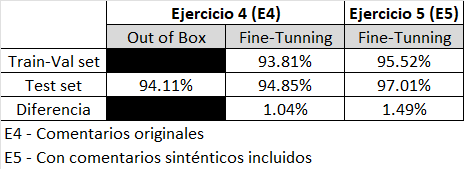

* En la tabla anterior se comparan los resultados obtenidos para el modelo Transformer de análisis de sentimiento aplicado en el ejercicio 4 (con los datos originales) y en el ejercicio 5 (con los comentarios sintéticos incluidos).
* En ambos ejercicios podemos observar una diferencia del 1-1.5% entre el desempeño del conjunto de datos de entrenamiento-validadación y el conjunto de prueba. Por lo que podemos concluir que no están sobreentrenados.
* En el ejercicios 4, observamos una diferencia de 0.74% entre el desempeño trabajando con el transformer de análisis de sentimiento de manera directa (Out-of-Box) y cuando ajustamos los parámetros (Fine-tunning) en el modelo con los comentarios originales obtenidos sobre el hotel seleccionado. Por lo que podemos concluir, que usando los datos desbalanceados no obtenemos una diferencia significativa para que valga la pena seguir entrenando el modelo.
* En el caso de ajustar los parámetros con los datos sintéticos balanceados 40%-60% sí observamos mejores resulados, con una ventaja de casi 2% porcentuales arriba de la precisión Out-of-box ejercicio 4. Si bien este es un mejor resultado, 2% pudiera no ser significativo para que valga la pena el esfuerzo y dependería del analista o el caso de uso específico para el que se aplique este análisis de sentimiento.
* Desde el punto de vista del hotel Fiesta Americana Monterrey Pabellón M, podría servirles este modelo para estar evaluando cada cierto tiempo los comentarios de la experiencia de los huéspedes en las distintas plataformas y encuestas para evaluar su servicio. Mientras más precisa sea la predicción del análisis de sentimiento, mejor van a poder invertir su tiempo en revisar el contenido de los negativos y enfocar acciones más puntuales para mejorar su servicio al cliente y cada vez lograr reducir lo más posible el % de comentarios negativos.

#**Bibliografía:**

* Modelos. (n.d.). Retrieved June 24, 2023, from https://somosnlp.org/recursos/open-source/modelos

* flax-community/gpt-2-spanish · Hugging Face. (n.d.). Retrieved June 24, 2023, from https://huggingface.co/flax-community/gpt-2-spanish?text=Me+llamo+Thomas+y+mi+principal

* edumunozsala/roberta_bne_sentiment_analysis_es · Hugging Face. (n.d.). Retrieved June 26, 2023, from https://huggingface.co/edumunozsala/roberta_bne_sentiment_analysis_es